In [1]:
from datetime import timedelta, datetime, tzinfo
import numpy as np
import matplotlib.pyplot as plt
import h5py
import argparse
import sharp
import sharpnsls2
# make graphics inline
# %matplotlib inline
%matplotlib notebook

# Input parameters

In [2]:
fname = '../data/scan_37466.h5' # HXN input file
niters = 101 # number of iterations

# SHARP-NSLS2 input parameters

sharpNSLS2 = sharpnsls2.PySharpNSLS2()

ccd_pixel_um = 55
sharpNSLS2.setPixelSize(ccd_pixel_um) # detector pixel size (um)

sharpNSLS2.setAmpMax(1.00) # up limit of allowed object amplitude range
sharpNSLS2.setAmpMin(0.95) # low limit of allowed object amplitude range
sharpNSLS2.setPhaMax(0.01) # up limit of allowed object phase range
sharpNSLS2.setPhaMin(-0.1) # low limit of allowed object amplitude range

sharpNSLS2.setAlpha(1.e-8) # regularization parameter 1/(probe**2 + alpha)
sharpNSLS2.setBeta(0.9) # optimization rate z(i+1) = z(i) + beta*d

sharpNSLS2.setStartUpdateObject(0)
sharpNSLS2.setStartUpdateProbe(0)

sharpNSLS2.setChunks(4) # number of chunks used 

# Reading an input file and setting frames, scan points, initial object and probe

In [3]:
print("reading a HXN input file ...");

t1 = datetime.now();
f = h5py.File(fname, "r")

diffamp = np.array(f['diffamp'])   # frames      

# scan data
scan_points = np.array(f['points'])     
x_range = np.asscalar(np.array(f['x_range']))
y_range = np.asscalar(np.array(f['y_range']))
dr_x = np.asscalar(np.array(f['dr_x']))
dr_y = np.asscalar(np.array(f['dr_y']))

z_m = np.asscalar(np.array(f['z_m'])) # detector-to-sample distance (m)
lambda_nm = np.asscalar(np.array(f['lambda_nm'])) # wavelength (nm)

f.close()
t2 = datetime.now();
print ("processing time: ", (t2 - t1))

nz, nx, ny = np.shape(diffamp)
points  = scan_points

print(nx,ny,nz, points.shape, z_m, lambda_nm, x_range, y_range, dr_x, dr_y)

# updating frames for sharp-nsls2

frames = []
emptyFrames = []

for i in range(0, nz):
    amp2 = diffamp[i]**2
    if np.sum(amp2) > 0.:
        frames.append(np.fft.fftshift(amp2))
    else :
        emptyFrames.append(i)
        
# scan direction and geometry correction handling
# recon-oriented operations

det_side = nx
real_pixel_size_um = 1.e6*z_m*lambda_nm*1e-3/(det_side*ccd_pixel_um)

print('real pixel size [um]:', real_pixel_size_um)

recon_points = -1*points
recon_points[0,:] *=-1 * np.abs(np.cos(15.*np.pi/180.))

xs = np.round(recon_points[0]/real_pixel_size_um) 
ys = np.round(recon_points[1]/real_pixel_size_um) 

xs -= min(xs)
ys -= min(ys)

xmax = max(xs)
ymax = max(ys)

xs = xs*real_pixel_size_um 
ys = ys*real_pixel_size_um 

real_translation = np.column_stack((ys, xs, np.zeros(ys.size)))
real_translation = real_translation * 1.0e-6 # recon_points in um

# generate an initial probe from frames

s = diffamp[0,:,:]
init_prb = np.fft.fftshift(np.fft.fftn(s)) / np.sqrt(np.size(s))

# generate an initial object

nx_obj = int(det_side + xmax)
ny_obj = int(det_side + ymax)

init_obj = np.random.uniform(0, 1.0, (nx_obj, ny_obj)) * np.exp(np.random.uniform(0, np.pi, (nx_obj, ny_obj))*1.j)

# setting the sharp-nsls2 parameters and containers

sharpNSLS2.setZ(z_m)
sharpNSLS2.setLambda(lambda_nm)

sharpNSLS2.setFrames(np.array(frames).astype(np.float32))
sharpNSLS2.setScan(real_translation.astype(np.float64))
sharpNSLS2.setInitProbe(np.asarray(init_prb).astype(np.complex64))
sharpNSLS2.setInitObject(init_obj.astype(np.complex64))

reading a HXN input file ...
processing time:  0:00:03.867901
128 128 40000 (2, 40000) 0.5 0.10333333333333333 1.99 1.99 0.01 0.01
real pixel size [um]: 0.007339015151515151


# Initialize the SHARP-NSLS2 containers

In [4]:
sharpNSLS2.init()

0

# Plot the initial object and probe

<IPython.core.display.Javascript object>


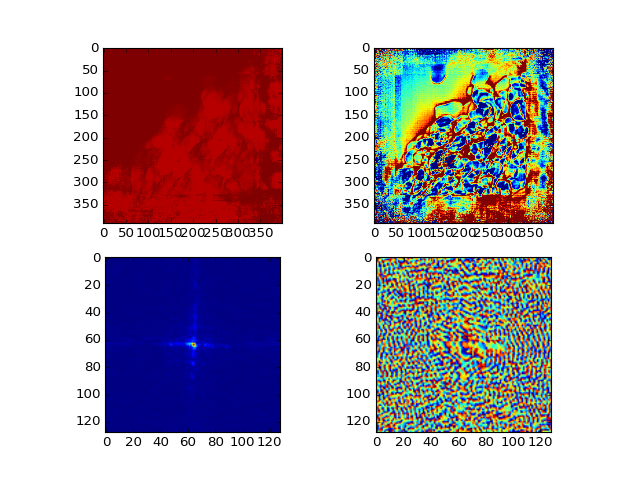

In [5]:
# f, (ax1, ax2) = plt.subplots(1, 2)
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

obj = sharpNSLS2.getObject()
ax1.imshow(np.abs(obj))
ax2.imshow(np.angle(obj))  

probe = sharpNSLS2.getProbe()
ax3.imshow(np.abs(probe))
ax4.imshow(np.angle(probe))  

f.canvas.draw()

# Run the reconstruction algorithm

In [6]:
# Define a function for processing and monitoring one iteration of the reconstruction algorithm

def make_step(i):
    sharpNSLS2.step()
    
    obj = sharpNSLS2.getObject()
    ax1.imshow(np.abs(obj))
    ax2.imshow(np.angle(obj))  
    
    probe = sharpNSLS2.getProbe()
    ax3.imshow(np.abs(probe))
    ax4.imshow(np.angle(probe))    
    
    f.canvas.draw()

# Run the reconstruction algorithm

t1 = datetime.now();
for i in range(niters):
    make_step(i)
t2 = datetime.now()    
print ("reconstruction time: ", (t2 - t1))

print(i, ", obj_err: ", sharpNSLS2.getObjectError(), ", prb_err: ", sharpNSLS2.getProbeError())

reconstruction time:  0:04:02.670428
100 , obj_err:  0.008073425851762295 , prb_err:  0.04219975695014
